# Siamese Address Similarity with TensorFlow
--------------------------

Here, we show how to perform address matching with a Siamese RNN model.

We start by loading the necessary libraries.

In [1]:
import os
import random
import string
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

model = __import__('06_siamese_similarity_model')

Start a graph session

In [2]:
sess = tf.Session()

Set the model parameters.

In [3]:
batch_size = 200     # How many addresses to train on in one batch
n_batches = 300      # How many batches to train on
max_address_len = 20 # How many character to crop/pad each address
margin = 0.25        # A sort of regularization parameter that allows for 'wiggle' room in bad predicted similarities.
num_features = 50    # RNN feature size
dropout_keep_prob = 0.8 # Dropout probability

We need a function to randomly create one typo in a string.

In [4]:
def create_typo(s):
    rand_ind = random.choice(range(len(s)))
    s_list = list(s)
    s_list[rand_ind]=random.choice(string.ascii_lowercase + '0123456789')
    s = ''.join(s_list)
    return(s)

# Generate data
street_names = ['abbey', 'baker', 'canal', 'donner', 'elm', 'fifth',
                'grandvia', 'hollywood', 'interstate', 'jay', 'kings']
street_types = ['rd', 'st', 'ln', 'pass', 'ave', 'hwy', 'cir', 'dr', 'jct']

# Define test addresses
test_queries = ['111 abbey ln', '271 doner cicle',
                '314 king avenue', 'tensorflow is fun']
test_references = ['123 abbey ln', '217 donner cir', '314 kings ave',
                   '404 hollywood st', 'tensorflow is so fun']

Get a batch of size n, half of which is similar addresses, half are not

In [5]:
def get_batch(n):
    # Generate a list of reference addresses with similar addresses that have
    # a typo.
    numbers = [random.randint(1, 9999) for i in range(n)]
    streets = [random.choice(street_names) for i in range(n)]
    street_suffs = [random.choice(street_types) for i in range(n)]
    full_streets = [str(w) + ' ' + x + ' ' + y for w,x,y in zip(numbers, streets, street_suffs)]
    typo_streets = [create_typo(x) for x in full_streets]
    reference = [list(x) for x in zip(full_streets, typo_streets)]
    
    # Shuffle last half of them for training on dissimilar addresses
    half_ix = int(n/2)
    bottom_half = reference[half_ix:]
    true_address = [x[0] for x in bottom_half]
    typo_address = [x[1] for x in bottom_half]
    typo_address = list(np.roll(typo_address, 1))
    bottom_half = [[x,y] for x,y in zip(true_address, typo_address)]
    reference[half_ix:] = bottom_half
    
    # Get target similarities (1's for similar, -1's for non-similar)
    target = [1]*(n-half_ix) + [-1]*half_ix
    reference = [[x,y] for x,y in zip(reference, target)]
    return(reference)

Define vocabulary dictionary (remember to save '0' for padding)

In [6]:
vocab_chars = string.ascii_lowercase + '0123456789 '
vocab2ix_dict = {char:(ix+1) for ix, char in enumerate(vocab_chars)}
vocab_length = len(vocab_chars) + 1

Define vocab one-hot encoding.  Here we get the actual indices for usage in the embedding lookup.

In [7]:
def address2onehot(address,
                   vocab2ix_dict = vocab2ix_dict,
                   max_address_len = max_address_len):
    # translate address string into indices
    address_ix = [vocab2ix_dict[x] for x in list(address)]

    # Pad or crop to max_address_len
    address_ix = (address_ix + [0]*max_address_len)[0:max_address_len]
    return(address_ix)

Now we define model placeholders.

In [8]:
address1_ph = tf.placeholder(tf.int32, [None, max_address_len], name="address1_ph")
address2_ph = tf.placeholder(tf.int32, [None, max_address_len], name="address2_ph")

y_target_ph = tf.placeholder(tf.int32, [None], name="y_target_ph")
dropout_keep_prob_ph = tf.placeholder(tf.float32, name="dropout_keep_prob")

Create embedding lookup. Here we use the identidy matrix so that we have a one-hot encoded lookup.

In [9]:
identity_mat = tf.diag(tf.ones(shape=[vocab_length]))
address1_embed = tf.nn.embedding_lookup(identity_mat, address1_ph)
address2_embed = tf.nn.embedding_lookup(identity_mat, address2_ph)

Now we define the model.  Please see the `06_siamese_similarity_model.py` for details.

In [10]:
# Define Model
text_snn = model.snn(address1_embed, address2_embed, dropout_keep_prob_ph,
                     vocab_length, num_features, max_address_len)

Now we can define our accuracy, loss, and prediction functions.  These come from the `06_siamese_similarity_model.py` model function.

In [11]:
# Define Accuracy
batch_accuracy = model.accuracy(text_snn, y_target_ph)
# Define Loss
batch_loss = model.loss(text_snn, y_target_ph, margin)
# Define Predictions
predictions = model.get_predictions(text_snn)

We declare our optimizer, training operation, and variable initialization.

In [12]:
# Declare optimizer
optimizer = tf.train.AdamOptimizer(0.01)
# Apply gradients
train_op = optimizer.minimize(batch_loss)

# Initialize Variables
init = tf.global_variables_initializer()
sess.run(init)

Now we loop through our training iterations and print out convergence statistics every 10 generations.

In [13]:
# Train loop
train_loss_vec = []
train_acc_vec = []
for b in range(n_batches):
    # Get a batch of data
    batch_data = get_batch(batch_size)
    # Shuffle data
    np.random.shuffle(batch_data)
    # Parse addresses and targets
    input_addresses = [x[0] for x in batch_data]
    target_similarity = np.array([x[1] for x in batch_data])
    address1 = np.array([address2onehot(x[0]) for x in input_addresses])
    address2 = np.array([address2onehot(x[1]) for x in input_addresses])
    
    train_feed_dict = {address1_ph: address1,
                       address2_ph: address2,
                       y_target_ph: target_similarity,
                       dropout_keep_prob_ph: dropout_keep_prob}

    _, train_loss, train_acc = sess.run([train_op, batch_loss, batch_accuracy],
                                        feed_dict=train_feed_dict)
    # Save train loss and accuracy
    train_loss_vec.append(train_loss)
    train_acc_vec.append(train_acc)
    # Print out statistics
    if b%10==0:
        print('Training Metrics, Batch {0}: Loss={1:.3f}, Accuracy={2:.3f}.'.format(b, train_loss, train_acc))

Training Metrics, Batch 0: Loss=0.554, Accuracy=0.500.
Training Metrics, Batch 10: Loss=0.087, Accuracy=0.730.
Training Metrics, Batch 20: Loss=0.049, Accuracy=0.700.
Training Metrics, Batch 30: Loss=0.076, Accuracy=0.720.
Training Metrics, Batch 40: Loss=0.029, Accuracy=0.760.
Training Metrics, Batch 50: Loss=0.038, Accuracy=0.720.
Training Metrics, Batch 60: Loss=0.026, Accuracy=0.715.
Training Metrics, Batch 70: Loss=0.010, Accuracy=0.775.
Training Metrics, Batch 80: Loss=0.001, Accuracy=0.810.
Training Metrics, Batch 90: Loss=0.005, Accuracy=0.760.
Training Metrics, Batch 100: Loss=-0.015, Accuracy=0.760.
Training Metrics, Batch 110: Loss=0.023, Accuracy=0.780.
Training Metrics, Batch 120: Loss=0.036, Accuracy=0.725.
Training Metrics, Batch 130: Loss=0.013, Accuracy=0.760.
Training Metrics, Batch 140: Loss=0.017, Accuracy=0.730.
Training Metrics, Batch 150: Loss=-0.003, Accuracy=0.780.
Training Metrics, Batch 160: Loss=-0.000, Accuracy=0.765.
Training Metrics, Batch 170: Loss=0.005

Let us test the algorithm on the test set of addresses.

In [14]:
# Calculate the nearest addresses for test inputs
# First process the test_queries and test_references
test_queries_ix = np.array([address2onehot(x) for x in test_queries])
test_references_ix = np.array([address2onehot(x) for x in test_references])
num_refs = test_references_ix.shape[0]
best_fit_refs = []
for query in test_queries_ix:
    test_query = np.repeat(np.array([query]), num_refs, axis=0)
    test_feed_dict = {address1_ph: test_query,
                      address2_ph: test_references_ix,
                      y_target_ph: target_similarity,
                      dropout_keep_prob_ph: 1.0}
    test_out = sess.run(text_snn, feed_dict=test_feed_dict)
    best_fit = test_references[np.argmax(test_out)]
    best_fit_refs.append(best_fit)

print('Query Addresses: {}'.format(test_queries))
print('Model Found Matches: {}'.format(best_fit_refs))

Query Addresses: ['111 abbey ln', '271 doner cicle', '314 king avenue', 'tensorflow is fun']
Model Found Matches: ['123 abbey ln', '217 donner cir', '314 kings ave', 'tensorflow is so fun']


This is great! The model generalizes to strings that aren't even addresses!!

Now let us plot the loss and accuracy.

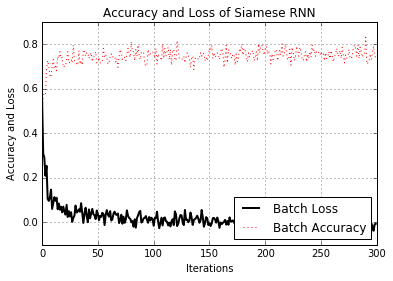

In [17]:
# Plot the loss and accuracy
plt.plot(train_loss_vec, 'k-', lw=2, label='Batch Loss')
plt.plot(train_acc_vec, 'r:', label='Batch Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy and Loss')
plt.title('Accuracy and Loss of Siamese RNN')
plt.grid()
plt.legend(loc='lower right')
plt.show()